In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
import itertools


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:

trainset = CIFAR10(root="./data", train=True,
                   download=True)

testset = CIFAR10(root="./data", train=False,
                  download=True)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


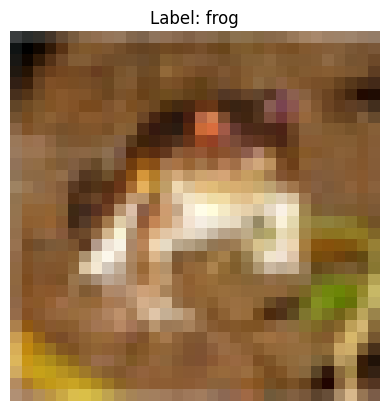

In [10]:
import matplotlib.pyplot as plt

classes = trainset.classes
print("Classes:", classes)

image, label = trainset[0]

image = image * 0.5 + 0.5

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.axis("off")
plt.show()


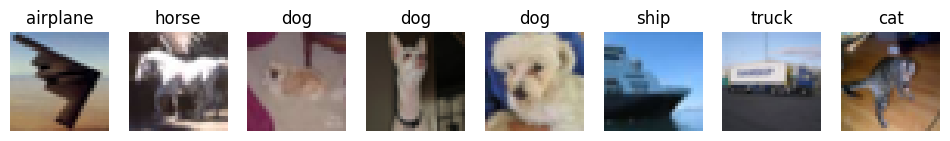

In [11]:
import numpy as np

def show_images(dataset, n=8):

    fig = plt.figure(figsize=(12, 4))

    for i in range(n):
        image, label = dataset[np.random.randint(len(dataset))]

        image = image * 0.5 + 0.5

        ax = fig.add_subplot(1, n, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(dataset.classes[label])
        ax.axis("off")

    plt.show()

show_images(trainset, n=8)


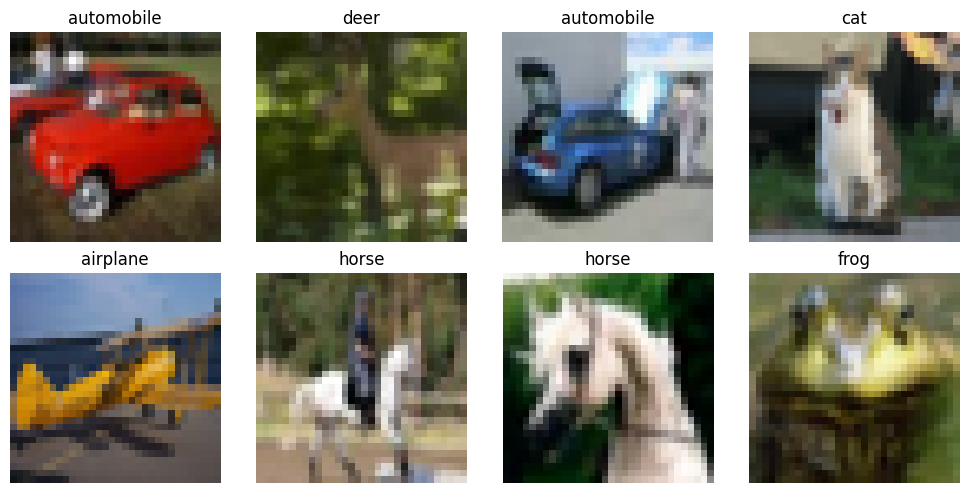

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images * 0.5 + 0.5

plt.figure(figsize=(10,5))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
def get_cnn(activation_fn):

    model = nn.Sequential(

        nn.Conv2d(3 , 32 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(32),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(32 , 64 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(64),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(64 , 128 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(128),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4 , 256),
        activation_fn,
        nn.Dropout(0.5),
        nn.Linear(256 , 10)
    )

    return model


In [5]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def initialize_weights(model, method):

    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)

            elif method == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

            elif method == "random":
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


In [7]:
def train_model(model, optimizer, epochs=10):

    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(epochs):

        model.train()
        running_loss = 0

        for images, labels in trainloader:

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader)}")


In [8]:
def evaluate(model):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [9]:
activations = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "leakyrelu": nn.LeakyReLU(0.01)
}

initializations = ["xavier", "kaiming", "random"]
optimizers_list = ["sgd", "adam", "rmsprop"]

best_accuracy = 0
best_model_state = None
best_config = None

for act_name, act_fn in activations.items():
    for init in initializations:
        for opt_name in optimizers_list:

            print("\n----------------------------------------------------------------")
            print(f"Running: {act_name} | {init} | {opt_name}")

            model = get_cnn(act_fn)
            initialize_weights(model, init)

            if opt_name == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            elif opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            train_model(model, optimizer, epochs=5)
            accuracy = evaluate(model)

            print("Accuracy:", accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()
                best_config = (act_name, init, opt_name)

print("\nBest Configuration:", best_config)
print("Best Accuracy:", best_accuracy)



----------------------------------------------------------------
Running: relu | xavier | sgd
Epoch [1/5] Loss: 1.6502966592683816
Epoch [2/5] Loss: 1.326878656664163
Epoch [3/5] Loss: 1.1419240563269466
Epoch [4/5] Loss: 1.0121072855446955
Epoch [5/5] Loss: 0.8997925358355198
Accuracy: 70.91

----------------------------------------------------------------
Running: relu | xavier | adam
Epoch [1/5] Loss: 1.5713114829929284
Epoch [2/5] Loss: 1.2382173138811154
Epoch [3/5] Loss: 1.11698462110956
Epoch [4/5] Loss: 1.0216087463414272
Epoch [5/5] Loss: 0.9492949677245391
Accuracy: 72.63

----------------------------------------------------------------
Running: relu | xavier | rmsprop
Epoch [1/5] Loss: 1.8382428184799526
Epoch [2/5] Loss: 1.2831976145429684
Epoch [3/5] Loss: 1.1173007437945022
Epoch [4/5] Loss: 1.0080152169212966
Epoch [5/5] Loss: 0.92386976814331
Accuracy: 67.07

----------------------------------------------------------------
Running: relu | kaiming | sgd
Epoch [1/5] Loss

In [13]:
torch.save(best_model_state, "best_cnn_cifar10.pth")
print("Best model saved!")


Best model saved!


In [14]:
resnet = models.resnet18(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):

    resnet.train()
    running_loss = 0

    for images, labels in trainloader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"ResNet Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

resnet_accuracy = evaluate(resnet)
print("ResNet Accuracy:", resnet_accuracy)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet Epoch 1, Loss: 0.9582529004348819
ResNet Epoch 2, Loss: 0.6631806667922707
ResNet Epoch 3, Loss: 0.5283177520155602
ResNet Epoch 4, Loss: 0.42778942333844006
ResNet Epoch 5, Loss: 0.3383607640481361
ResNet Accuracy: 79.85


In [8]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavkhanna2006","key":"00f08c5e82583a2a7535cbb6d38d33a3"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
!pip install kaggle


In [11]:
!kaggle competitions download -c dogs-vs-cats


 88% 716M/812M [00:03<00:02, 45.8MB/s]
100% 812M/812M [00:04<00:00, 210MB/s] 


In [12]:
!unzip dogs-vs-cats.zip


Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [13]:
!unzip train.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [14]:
import os

os.makedirs("/content/data/train/cats", exist_ok=True)
os.makedirs("/content/data/train/dogs", exist_ok=True)
os.makedirs("/content/data/val/cats", exist_ok=True)
os.makedirs("/content/data/val/dogs", exist_ok=True)

print("Folders created ✅")


Folders created ✅


In [15]:
import shutil
from sklearn.model_selection import train_test_split

files = os.listdir("/content/train")

cats = [f for f in files if f.startswith("cat")]
dogs = [f for f in files if f.startswith("dog")]

train_cats, val_cats = train_test_split(cats, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dogs, test_size=0.2, random_state=42)

# Move files
for f in train_cats:
    shutil.move(f"/content/train/{f}", f"/content/data/train/cats/{f}")

for f in train_dogs:
    shutil.move(f"/content/train/{f}", f"/content/data/train/dogs/{f}")

for f in val_cats:
    shutil.move(f"/content/train/{f}", f"/content/data/val/cats/{f}")

for f in val_dogs:
    shutil.move(f"/content/train/{f}", f"/content/data/val/dogs/{f}")

print("Dataset structured successfully ✅")


Dataset structured successfully ✅


In [16]:
!ls data/train


cats  dogs


In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = datasets.ImageFolder("/content/data/train", transform=transform)
val_dataset = datasets.ImageFolder("/content/data/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Classes: ['cats', 'dogs']
Train size: 20000
Val size: 5000


In [18]:
import torch.nn as nn

def get_cnn(activation_fn):

    model = nn.Sequential(

        nn.Conv2d(3,32,3,padding=1),
        nn.BatchNorm2d(32),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(32,64,3,padding=1),
        nn.BatchNorm2d(64),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128*28*28,256),
        activation_fn,
        nn.Dropout(0.5),
        nn.Linear(256,2)
    )

    return model


In [19]:
def initialize_weights(model, method):

    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)

            elif method == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

            elif method == "random":
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


In [20]:
def train_model(model, optimizer, epochs=3):

    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


In [21]:
def evaluate(model):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [31]:
import torch.optim as optim

activations = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "leakyrelu": nn.LeakyReLU(0.01)
}

initializations = ["xavier", "kaiming", "random"]
optimizers_list = ["sgd", "adam", "rmsprop"]

best_accuracy = 0
best_model_state = None
best_config = None

results = {}

for act_name, act_fn in activations.items():
    for init in initializations:
        for opt_name in optimizers_list:

            print("\n====================================")
            print(f"Running: {act_name} | {init} | {opt_name}")

            model = get_cnn(act_fn)
            initialize_weights(model, init)

            if opt_name == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            elif opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            train_model(model, optimizer, epochs=3)
            accuracy = evaluate(model)

            print("Validation Accuracy:", accuracy)

            results[(act_name, init, opt_name)] = accuracy

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()
                best_config = (act_name, init, opt_name)

print("\nBest Configuration:", best_config)
print("Best Accuracy:", best_accuracy)



Running: relu | xavier | sgd
Epoch 1, Loss: 0.7984316875457763
Epoch 2, Loss: 0.6937312454223633
Epoch 3, Loss: 0.6937060885429382
Validation Accuracy: 50.0

Running: relu | xavier | adam
Epoch 1, Loss: 2.2976649423599245
Epoch 2, Loss: 0.6337789858818054
Epoch 3, Loss: 0.6193554392337799
Validation Accuracy: 67.96

Running: relu | xavier | rmsprop
Epoch 1, Loss: 9.079844519853593
Epoch 2, Loss: 0.6778652616500854
Epoch 3, Loss: 0.6538328244686127
Validation Accuracy: 62.62

Running: relu | kaiming | sgd
Epoch 1, Loss: 0.7927037767410279
Epoch 2, Loss: 0.6936625372886658
Epoch 3, Loss: 0.6937054528236389
Validation Accuracy: 50.0

Running: relu | kaiming | adam
Epoch 1, Loss: 1.9067255459785462
Epoch 2, Loss: 0.6481429868221283
Epoch 3, Loss: 0.6449586316108704
Validation Accuracy: 68.66

Running: relu | kaiming | rmsprop
Epoch 1, Loss: 6.4325841087341304
Epoch 2, Loss: 0.6875937593460083
Epoch 3, Loss: 0.6828331472873688
Validation Accuracy: 68.78

Running: relu | random | sgd
Epoch 

In [22]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    resnet.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"ResNet Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

resnet_accuracy = evaluate(resnet)
print("ResNet Validation Accuracy:", resnet_accuracy)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet Epoch 1, Loss: 0.11856732070446015
ResNet Epoch 2, Loss: 0.08040825268812478
ResNet Epoch 3, Loss: 0.07221679701134562
ResNet Validation Accuracy: 97.62
